# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка датасетов

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed = 12345
)

Found 7591 validated image filenames.


### Исследование csv-файла

In [3]:
# Общая информация по таблице
display(labels.head(10))
print('=======================================')
labels.info()
print('=======================================')
# Проверка на явные дубликаты
labels.duplicated().sum()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


0

Все данные в столбцах имеют соответствующий тип данных. Не найдено пропусков и дубликатов.

Изучим распределение возраста в выборке:

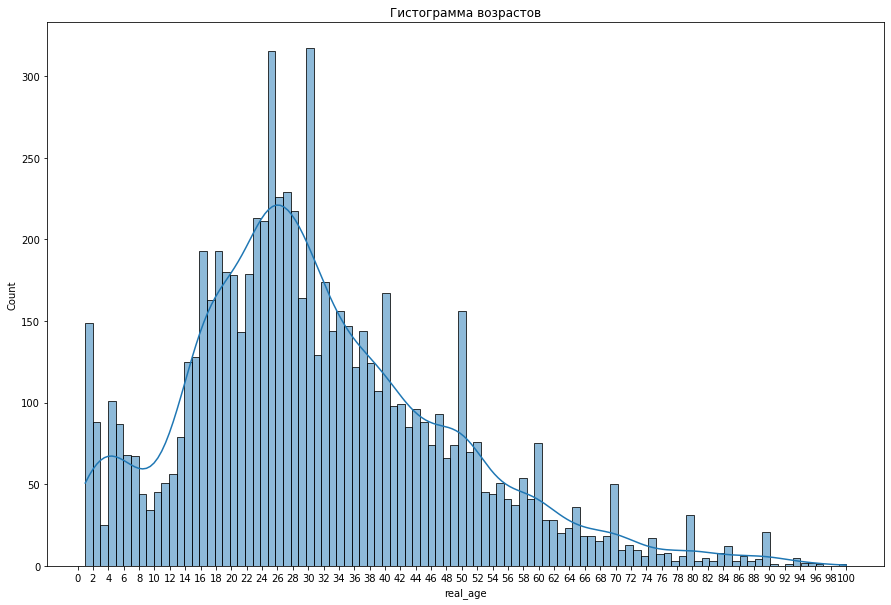

In [4]:
plt.figure(figsize=(15, 10))
sns.histplot(x=labels['real_age'], bins=100, kde=True)
plt.title('Гистограмма возрастов')
ticks = range(0, labels['real_age'].max()+1, 2)
plt.xticks(ticks)
plt.show()

### Исследование фотосета

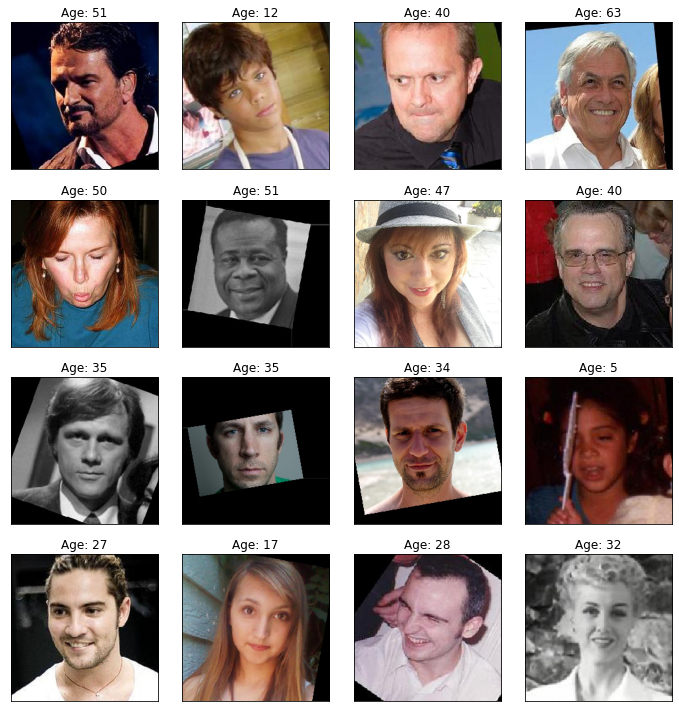

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Для приведенных 16 фотографий разметка возраста выглядит адекватно.

**Вывод:** В ходе предварительного исследования таблиц с метками возрастов и соответствующих фото было выявлено:
* В датасетах большое число данных/фото по людям 16-32 лет, меньше данных по 8-14 летним. При этом данные по возрастам сгруппированы в группы возрастов кратные 10 (30, 40, 50 и т.д.). Все это может снизить точность прогнозов нейросети.

* На случайных 16 фотографиях ракурсы съемки лиц, повороты изображения и т.д. самые разные - возможно такое разнообразие позволит модлеи обучатся лучше и аугментация не понадобится.

## Обучение модели

Код для GPU-секции:

```python
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.0003)

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed = 12345
    )

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory= path + 'final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed = 12345
    )

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

**Вывод модели:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 47s - loss: 187.3462 - mae: 10.1636 - val_loss: 553.8498 - val_mae: 18.4849
Epoch 2/20
178/178 - 39s - loss: 77.1484 - mae: 6.6549 - val_loss: 407.8548 - val_mae: 15.1386
Epoch 3/20
178/178 - 38s - loss: 43.4193 - mae: 5.0724 - val_loss: 445.3108 - val_mae: 16.1577
Epoch 4/20
178/178 - 38s - loss: 31.9024 - mae: 4.3251 - val_loss: 122.8404 - val_mae: 8.4954
Epoch 5/20
178/178 - 38s - loss: 20.5965 - mae: 3.4884 - val_loss: 107.6292 - val_mae: 7.8825
Epoch 6/20
178/178 - 38s - loss: 14.5288 - mae: 2.9376 - val_loss: 77.8576 - val_mae: 6.7127
Epoch 7/20
178/178 - 38s - loss: 10.6149 - mae: 2.5074 - val_loss: 65.8608 - val_mae: 6.1297
Epoch 8/20
178/178 - 38s - loss: 8.0414 - mae: 2.1742 - val_loss: 73.7008 - val_mae: 6.4947
Epoch 9/20
178/178 - 38s - loss: 7.3776 - mae: 2.0652 - val_loss: 72.5018 - val_mae: 6.5972
Epoch 10/20
178/178 - 39s - loss: 7.3674 - mae: 2.0378 - val_loss: 70.9303 - val_mae: 6.3049
Epoch 11/20
178/178 - 38s - loss: 7.9071 - mae: 2.1280 - val_loss: 71.1919 - val_mae: 6.4928
Epoch 12/20
178/178 - 39s - loss: 7.2746 - mae: 2.0625 - val_loss: 72.7483 - val_mae: 6.4172
Epoch 13/20
178/178 - 38s - loss: 6.7533 - mae: 1.9712 - val_loss: 70.9767 - val_mae: 6.2508
Epoch 14/20
178/178 - 38s - loss: 7.5544 - mae: 2.0964 - val_loss: 71.4744 - val_mae: 6.4247
Epoch 15/20
178/178 - 38s - loss: 7.9356 - mae: 2.1319 - val_loss: 72.4659 - val_mae: 6.3899
Epoch 16/20
178/178 - 38s - loss: 8.2656 - mae: 2.1749 - val_loss: 91.6567 - val_mae: 6.8948
Epoch 17/20
178/178 - 38s - loss: 8.9458 - mae: 2.2508 - val_loss: 67.0246 - val_mae: 6.2088
Epoch 18/20
178/178 - 38s - loss: 8.3384 - mae: 2.1874 - val_loss: 71.6203 - val_mae: 6.3745
Epoch 19/20
178/178 - 38s - loss: 7.7167 - mae: 2.1153 - val_loss: 70.6181 - val_mae: 6.3808
Epoch 20/20
178/178 - 38s - loss: 7.2482 - mae: 2.0322 - val_loss: 75.0534 - val_mae: 6.4276
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 75.0534 - mae: 6.4276
Test MAE: 6.4276

```

## Анализ обученной модели

Для решения задачи регресии определения возраста человека по фотографии была использована нейросеть архитектуры ResNet50 (50 слоев) предварительно предобученная. В качестве метрики использовалась MAE, а в качестве функции потерь MSE (в этом случае модель обучается быстрее). Было исследовано 3 модели (*lr* - шаг алгоритма, *epochs* - количество эпох):
* *lr*=0.001 *epochs*=10 - MAE на валидационной выборке - 7.6163
* *lr*=0.001 *epoch*s=20 - MAE на валидационной выборке - 7.5566
* *lr*=0.0003 *epochs*=20 - MAE на валидационной выборке - 6.4276

Можно видеть что увеличение шага оптимизатора Adam и числа эпох увеличивает точность модели. Вывод процесса обучения для последней модели приведен выше. Из него можно видеть что начиная с 8 эпохи модель на валидационной выборке перестает заметно улучшаться. 

## Вывод

Для системы компьютерного зрения сетевого супермаркета «Хлеб-Соль» была разработана модель, которая по фотографии определяет приблизительный возраст человека. Для обучения был взят набор фотографий людей с указанием возраста.

Был проведен исследовательский анализ возрастной выборки, в ходе которого были выявлены следующие недостатки: 
* сравнительно малое количество данных по возрастной группе 8-14 лет; 
* округление возрастов к кратным 10

Для определения возраста клиентов была использована нейросеть архитектуры ResNet50 с оптимизатором Adam шагом 3e-4 и 20 эпохами. По итогу метрика MAE на валидационной выборке составила 6.4276 - т.е. нейросеть ошибается в среднем примерно на 6 лет.

Возможный альтернативный вариант - это решения задачи классификации, а не регрессии: вместо точного возраста будет определяться принадлежность клиента к определенной группе - от 10-20 лет, 20-30 лет и т.д.